In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat

#import pysindy as ps
import pysindy

# Quasiperiodic cavity flow

This example demonstrates the use of SINDy to learn a model for the quasiperiodic dynamics in a shear-driven cavity at Re=7500, following [Callaham, Brunton, and Loiseau (2021)](https://arxiv.org/abs/2106.02409).  Since we'll work with complex-valued DMD coefficients and complex values aren't supported by default in PySINDy, this is also an example of how to use some of the lower-level features of SINDy like directly accessing the sparse optimizers.

As in the cylinder wake example (see notebook 3), the reduced-order model appproximates the 2D time-varying velocity field $\mathbf{u}(\mathbf{x}, t)$ with the POD expansion
$$
\mathbf{u}(\mathbf{x}, t) = \sum_{j=1}^r \boldsymbol{\psi}_j(\mathbf{x}) a_j(t).
$$
The POD expansion gives us the spatial modes $\boldsymbol{\psi}_j(\mathbf{x})$ and a time series for the coefficients $a_j(t)$.  This time series serves as the training data; if we can learn an ODE model
$$
\dot{\mathbf{a}} = \mathbf{f}(\mathbf{a})
$$
for the coefficients then we can evaluate the model cheaply and reconstruct the full velocity field.

## 1. POD analysis

Since the full Direct Numerical Solution (DNS) fields and POD modes are too large to store in a standard GitHub repository, we'll just start with the set of POD coefficients $\mathbf{a}(t)$.  Since our POD modes represent velocity components, the squared amplitude of each mode $|a_j|^2$ is conveniently equivalent to the kinetic energy content of that mode and also the singular values or POD eigenvalues (see standard references on POD like [this](https://www.cambridge.org/core/books/turbulence-coherent-structures-dynamical-systems-and-symmetry/4D353229751BBB24C8C266B4714CA9F2) or [this](https://arc.aiaa.org/doi/10.2514/1.J056060)).

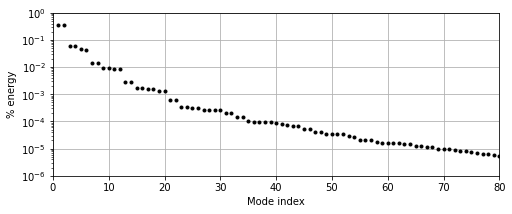

In [2]:
data = loadmat("data/cavityPOD.mat")

t_dns = data['t'].flatten()
dt_dns = t_dns[1]-t_dns[0]
a_dns = data['a']
singular_vals = data['svs'].flatten()

plt.figure(figsize=(8, 3))
plt.semilogy(1+np.arange(len(singular_vals)), singular_vals/sum(singular_vals), 'k.')
plt.grid()
plt.xlim([0, 80])
plt.ylim([1e-6, 1e0])
plt.ylabel("% energy")
plt.xlabel("Mode index")

plt.show()

Although the energy doesn't decay quite as quickly as in the cylinder example, by $r=64$ the POD modes contain $\sim 0.001 \%$ of the total fluctuating (mean-subtracted) kinetic energy.  We'll arbitrarily choose this as a truncation value for now, since it leaves a small residual and is a nice round multiple of 2.

It is also helpful to look at the power spectral density; note the approximately discrete peaks in log-energy.  These are characteristic of quasiperiodic dynamics generated by oscillations at incommensurate frequencies.

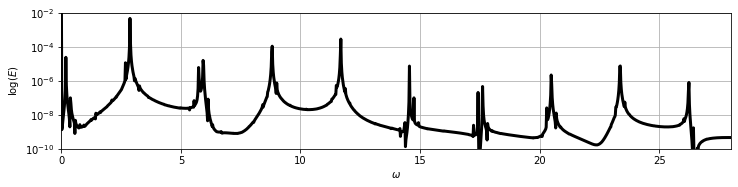

In [3]:
# Basic power spectral density estimate using FFT
def psd_est(E, dt=1):
    Ehat = np.abs((dt*np.fft.fft(E))**2)
    Ehat = Ehat[:int(len(Ehat)/2)]
    N = len(Ehat)
    freq = 2*np.pi*np.arange(N)/(2*dt*N)  # Frequencies in rad/s
    return Ehat, freq

E_dns = np.sum(a_dns**2, axis=1)
psd, freq = psd_est(E_dns, dt=dt_dns)
    
plt.figure(figsize=(12, 2.5))
plt.semilogy(freq, psd, 'k', lw=3)
plt.xlim([0, 28])
plt.ylim([1e-10, 1e-2])
plt.xlabel('$\omega$')
plt.ylabel('$\log(E)$')
plt.grid()
plt.show()


## 2. Galerkin projection

The standard approach to POD-based reduced-order modeling is to construct a physics-based model for $\mathbf{f}(\mathbf{a})$ using a technique called _Galerkin projection_ (see the paper referenced above for details).  The model is of the form
$$
\dot{\mathbf{a}} = \mathbf{C} + \mathbf{L}\mathbf{a} + \mathbf{Q}(\mathbf{a}),
$$
including terms that are constant, linear, and quadratic in $\mathbf{a}$ ($\mathbf{C}$, $\mathbf{L}$, and $\mathbf{Q}$, respectively).  In general, all of these arrays will be dense, so for a model containing $r$ modes the cost of simulating the reduced-order model scales with $\mathcal{O}(r^3)$.  This can get fairly expensive, but even worse, even if great care is taken in constructing the Galerkin system, this type of model is often inaccurate or unstable.  Our goal is to use SINDy to learn a more efficient and accurate approximation to $\mathbf{f}(\mathbf{a})$, but Galerkin is a convenient baseline

Without getting into the details of computing the Galerkin projection, we'll assume we've already computed this model.

In [4]:
class GalerkinROM():
    
    def __init__(self, file):
        model_dict = loadmat(file)
        self.C = model_dict['C'][0]
        self.L = model_dict['L']
        self.Q = model_dict['Q']
        
    def integrate(self, x0, t, r=None,
                  rtol=1e-3, atol=1e-6):
        if r is None: r=len(C)
            
        # Truncate model as indicated
        C = self.C[:r]
        L = self.L[:r, :r]
        Q = self.Q[:r, :r, :r]
            
        # RHS of POD-Galerkin model, for time integration
        rhs = lambda t, x: C + (L @ x) + np.einsum('ijk,j,k->i', Q, x, x)
        
        sol = solve_ivp(rhs, (t[0], t[-1]), x0[:r], t_eval=t, rtol=rtol, atol=atol)
        return sol.y.T

In [5]:
# Simulate Galerkin system at various truncation levels

galerkin_model = GalerkinROM('data/cavityGalerkin.mat')

dt_rom = 1e-2
t_sim = np.arange(0, 300, dt_rom)

a0 = a_dns[0, :]


a_gal6 = galerkin_model.integrate(a0, t_sim, r=6,
               rtol=1e-8, atol=1e-8)
a_gal16 = galerkin_model.integrate(a0, t_sim, r=16,
               rtol=1e-8, atol=1e-8)
a_gal64 = galerkin_model.integrate(a0, t_sim, r=64,
               rtol=1e-8, atol=1e-8)

In [6]:

a_gal6 = galerkin_model.integrate(a0, t_sim, r=6,
               rtol=1e-8, atol=1e-8)

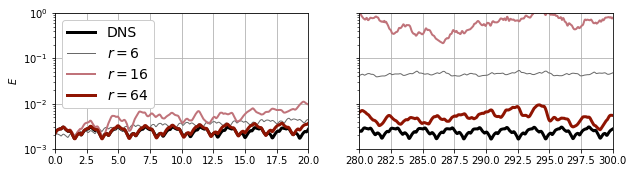

In [7]:
# Plot energy

rE = 64
E_dns = np.sum(a_dns[:, :rE]**2, 1)
E_gal6 = np.sum(a_gal6[:, :rE]**2, 1)
E_gal16 = np.sum(a_gal16[:, :rE]**2, 1)
E_gal64 = np.sum(a_gal64[:, :rE]**2, 1)

plt.figure(figsize=(10, 2.5))
plt.subplot(121)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=1, c='dimgrey')
plt.plot(t_sim, E_gal16, label='$r=16$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal64, label='$r=64$', lw=3, c='xkcd:brick red')
plt.gca().set_yscale('log')
plt.xlim([0, 20])
plt.ylim([1e-3, 1e0])
plt.ylabel('$E$')
plt.legend(loc=0, fancybox=True, framealpha=1, fontsize=14)
plt.grid()

plt.subplot(122)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=1, c='dimgrey')
plt.plot(t_sim, E_gal16, label='$r=16$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal64, label='$r=64$', lw=3, c='xkcd:brick red')
plt.gca().set_yscale('log')
plt.xlim([280, 300])
plt.ylim([1e-3, 1e0])
plt.gca().set_yticklabels([])
plt.grid()

plt.subplots_adjust(wspace=0.2)
plt.show()

Even though the residual energy from truncation is tiny, the Galerkin model still diverges from the true behavior of the flow.  This is still true if the truncation is extended further, but you can probably tell that even at $r=64$ the cubic scaling of the ODE system is starting to catch up with us (although it's still a lot faster than the DNS!).

## 3. Naive SINDy model

As a first pass at improving the reduced-order model, let's try learning a SINDy model for the POD coefficients, just like we did for the cylinder wake.  The form of the Galerkin model suggests that we should use quadratic terms in the library, but [physical considerations](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/hierarchy-of-lowdimensional-models-for-the-transient-and-posttransient-cylinder-wake/0F114BEB5DD20B7342E99ED8D0070C01) suggest that it would probably be better to include cubic terms.  To keep the size of the library manageable, we won't go higher than that (feel free to try, but it probably won't help).

For truncation level, it might be nice to keep a high level of truncation ($r=64$, say), but we have to keep in mind that the library dimension grows _combinatorially_ in the number of variables.  Based on the singular values above, $r=6$ seems like a better place to start (though again, go ahead and experiment).

Also note that we're including _all_ of the DNS data as training data.  This is generally poor practice in machine learning, but in this particular case we expect that the solution stays on its attractor after any initial transients die away, so even if we split the data into train/test we wouldn't really have statistical independence.  You may well wonder if the resulting model is overfit, but a better way to test is by seeing if transient trajectories converge to the attractor (more on this later).

In [8]:
r=6  # POD truncation

x_train = a_dns[:, :r]
t_train = t_dns.copy()

# Fit the model
optimizer = ps.STLSQ(threshold=1e-1)
library = ps.PolynomialLibrary(degree=3)
model = ps.SINDy(
    optimizer=optimizer, feature_library=library
)
model.fit(x_train, t_train, quiet=True)
model.print()

x0' = -11.217 x1 + 1.341 x2 + -2.102 x3 + -0.382 x4 + -0.278 x5 + -12.661 x0^2 + 27.417 x0 x1 + -19.967 x0 x2 + -33.526 x0 x3 + -8.329 x0 x4 + 20.076 x0 x5 + 12.937 x1^2 + 41.729 x1 x2 + -17.515 x1 x3 + -8.588 x1 x4 + 35.170 x1 x5
x1' = 11.365 x0 + 2.124 x2 + 1.070 x3 + -0.329 x4 + -3.751 x0^2 + -13.742 x0 x1 + -6.588 x0 x3 + 22.120 x0 x4 + -41.226 x0 x5 + 15.026 x1^2 + 1.790 x1 x2 + 10.799 x1 x3 + -13.911 x1 x4 + 32.718 x1 x5 + -28.736 x2^2 + -15.900 x2 x4 + 15.392 x2 x5 + -35.223 x3^2
x2' = -0.035 x1 + -17.262 x3 + 0.433 x4 + 0.149 x5 + 25.390 x0^2 + -104.729 x0 x1 + -27.225 x0 x3 + -13.690 x0 x4 + 4.379 x0 x5 + -26.246 x1^2 + -24.250 x1 x2 + -3.107 x1 x3 + 5.501 x1 x4 + -18.018 x1 x5 + 60.804 x2 x5 + -12.217 x3 x4 + 68.413 x3 x5
x3' = 0.020 x1 + 17.688 x2 + 0.649 x4 + 0.232 x5 + 46.935 x0^2 + 45.875 x0 x1 + 25.949 x0 x2 + -7.570 x0 x4 + 21.924 x0 x5 + -48.821 x1^2 + 4.273 x1 x2 + -27.062 x1 x3 + -13.468 x1 x4 + 18.250 x2 x4 + -73.548 x2 x5 + 59.473 x3 x5
x4' = 0.148 x2 + -0.939 x3 +

So, how did that go?

In [9]:
# Simulate the model

a_sindy = model.simulate(a0[:r], t_sim)

E_sindy = np.sum(a_sindy[:, :rE]**2, 1)

/usr/local/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


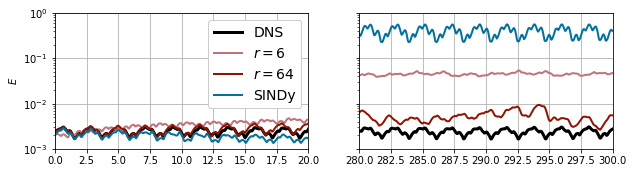

In [10]:
plt.figure(figsize=(10, 2.5))
plt.subplot(121)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal64, label='$r=64$', lw=2, c='xkcd:brick red')
plt.plot(t_sim, E_sindy, label='SINDy', lw=2, c='xkcd:ocean blue')
plt.gca().set_yscale('log')
plt.legend(loc=0, fancybox=True, framealpha=1, fontsize=14)
plt.xlim([0, 20])
plt.ylim([1e-3, 1e0])
plt.ylabel('$E$')
plt.grid()

plt.subplot(122)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal64, label='$r=64$', lw=2, c='xkcd:brick red')
plt.plot(t_sim, E_sindy, label='SINDy', lw=2, c='xkcd:ocean blue')
plt.gca().set_yscale('log')
plt.xlim([280, 300])
plt.ylim([1e-3, 1e0])
plt.gca().set_yticklabels([])
plt.grid()

plt.subplots_adjust(wspace=0.2)
plt.show()

That's actually worse than the Galerkin system of the same dimension!

There are a few things we could try to improve this:
* Parameter tuning: try different thresholds, different libraries, truncation, etc.
* Ensemble SINDy
* Different optimizer: sequential least squares (STLSQ) is easy and fast, but often not as good as a more advanced algorithm like SR3
* Use quadratic optimization with constraints (e.g. Trapping SINDy)

Any of these might work and could be worth trying, but in this case we can get some extra mileage by thinking about the problem from a dynamical systems point of view.

## 4. Dynamic mode decomposition

The first thing that's helpful in this case is related to the point spectrum shown above.  Since there are oscillations that occur at approximately discrete frequencies, this flow is a natural candidate for dynamic mode decomposition ([Schmid (2010)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/dynamic-mode-decomposition-of-numerical-and-experimental-data/AA4C763B525515AD4521A6CC5E10DBD4)), which looks for spatial modes associated with specific frequencies.  Again, we'll skip over many details of how DMD is computed except to say that this is an example of the simple _exact DMD_ algorithm (see [Tu, _et al._ (2014)](https://arxiv.org/abs/1312.0041)).

The core idea is that we want to approximate a discrete-time evolution operator $\mathbf{A}$ that steps the velocity field forward in time:
$$
\mathbf{u}(\mathbf{x}, t_{k+1}) \approx \mathbf{A} \mathbf{u}(\mathbf{x}, t_k).
$$
In particular, we want to look at the "spectral properties" of $\mathbf{A}$, or the eigenvectors and eigenvalues.
The operator $\mathbf{A}$ typically can't be formed explicitly, so we look for a low-rank approximation.  In the exact DMD algorithm, this uses the representation of the flow field in the POD basis, so that
$$
\mathbf{a}(t_{k+1}) \approx \tilde{\mathbf{A}} \mathbf{a}({t_k}),
$$
where $\tilde{\mathbf{A}} = \boldsymbol{\Psi}^T \mathbf{A} \boldsymbol{\Psi}$ is the low-rank approximation of the operator $\mathbf{A}$ in the subspace spanned by the POD modes.
We approximate $\tilde{\mathbf{A}}$ with a pseudoinverse of the time-shifted data.  This is only an $r \times r$ matrix, so its eigenvalue decomposition $\tilde{\mathbf{A}} = \mathbf{V} \boldsymbol{\Lambda} \mathbf{V}^{-1}$ can easily be computed.

In [4]:
from scipy import linalg
dt_dns = t_dns[1]-t_dns[0]

# Leave off shift mode if not computed with modred
X = a_dns[:-1, :].T  # First time step
Y = a_dns[1:, :].T   # Time-shifted matrix so that Y = AX

# Low-rank dynamics via pseudoinverse
A = Y @ linalg.pinv(X)

# Eigendecomposition of low-rank matrix (note these are discrete-time eigenvalues)
dt_evals, V = linalg.eig(A)  
evals = np.log(dt_evals)/dt_dns

The _DMD modes_ $\boldsymbol{\Phi}$ are then linear combinations of the POD modes given by the eigenvectors of $\tilde{\mathbf{A}}$:
$$
\boldsymbol{\Phi} = \boldsymbol{\Psi} \mathbf{V}
$$

Even though the DMD modes $\boldsymbol{\Phi}$ each have a specific frequency associated with them, we can simply treat them as a different set of spatial modes from the POD modes, so that the flow field can be approximated with either the POD or DMD modes:
$$
\mathbf{u}(\mathbf{x}, t) \approx \sum_{j=1}^r \boldsymbol{\psi}_j(\mathbf{x}) a_j(t) = \sum_{j=1}^r \boldsymbol{\phi}_j(\mathbf{x}) \alpha_j(t).
$$
Note that the POD and DMD modes span the same linear subspace; the generalized coordinates $\{a_j\}$ and $\{\alpha_j\}$ are just rotations of one another given by $\mathbf{V}$:
$$
\boldsymbol{\alpha} = \mathbf{V}^{-1} \mathbf{a}.
$$

The DMD coefficients aren't sorted in any order the way the POD coefficients are, so it's helpful to arrange them by descending average energy content (as for POD).

In [5]:
a_dmd = (linalg.inv(V) @ a_dns.T ).T
E_dmd = np.mean(abs(a_dmd)**2, axis=0)

sort_idx = np.argsort(-E_dmd)
V = V[:, sort_idx]
evals = evals[sort_idx]

a_dmd = (linalg.inv(V) @ a_dns.T ).T

Why do we bother with DMD if it's the same subspace as POD?

The main reason is that for a flow with discrete power spectrum, the DMD coefficients will be closer to pure oscillation, which can make it easier to identify a simple dynamical systems model.

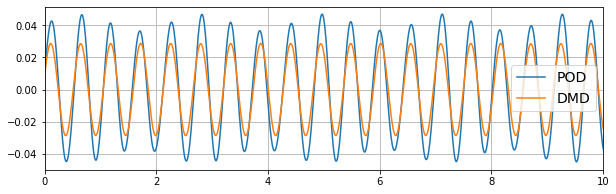

In [6]:
# Compare the most energetic POD and DMD coefficients
plt.figure(figsize=(10, 3))
plt.plot(t_dns, a_dns[:, 0], label='POD')
plt.plot(t_dns, np.real(a_dmd[:, 0]), label='DMD')
plt.xlim([0, 10])
plt.legend(fontsize=14)
plt.grid()
plt.show()

Notice the DMD coefficient has slightly lower amplitude (less energy), but is almost a pure sine, whereas the POD coefficient time series looks like it contains more frequencies.  This tends to make it easier to model the DMD coefficients; pure sine waves can be generated by a simple oscillator model, whereas mixed frequencies and energy transfers between modes are more complicated to construct.

## 5. Nonlinear correlations

We could just try to identify another SINDy model starting from the DMD coefficients.  Since we're in a better coordinate system, that might be more successful.  However, we can do better by thinking a little about the flow from a dynamical systems perspective.

The power spectrum shown above has two main frequency components ($\omega \approx 3$ and $\omega \approx 12$); the rest of the peaks can be explained by sums and differences of these two frequencies.  This tells us that the quasiperiodic dynamics is likely as simple as two oscillators with incommensurate frequencies.  To check this, let's look for the DMD modes with frequencies corresponding to the main frequency components.

In [7]:
print(np.imag(evals))

[-11.68160121  11.68160121  23.3633855  -23.3633855    2.87216596
  -2.87216596 -14.5534704   14.5534704   -8.80949322   8.80949322
  26.23475915 -26.23475915  35.04441009 -35.04441009  20.48989744
 -20.48989744 -37.91779496  37.91779496 -32.15789177  32.15789177
   5.74414378  -5.74414378 -46.88636052  46.88636052  -5.9372479
   5.9372479   17.49972783 -17.49972783 -50.05461915  50.05461915
 -43.84234145  43.84234145  17.63081774 -17.63081774  29.04011557
 -29.04011557  -3.06146071   3.06146071 -29.21222738  29.21222738
 -57.19040688  57.19040688  40.70691791 -40.70691791  61.75720086
 -61.75720086 -41.12203043  41.12203043  -8.63718665   8.63718665
  16.75829494 -16.75829494 -54.1833673   54.1833673  -73.61940149
  73.61940149 -66.99410081  66.99410081 -82.48060616  82.48060616
   0.17479624  -0.17479624 -93.02110434  93.02110434]


The first pair of modes (which are complex-conjugates) are near $\omega=12$, while the fifth and sixth modes are near $\omega=3$.  If we looked at the flow fields corresponding to these modes we'd find that the $\omega_s=11.7$ frequency corresponds to shear layer oscillations, while the low-frequency oscillations at $\omega_c=2.9$ are inner cavity motions (see [this paper](https://arxiv.org/pdf/2106.02409.pdf) on this flow for visualizations and more detail).

If the dynamics really can be represented by two oscillators with incommensurate frequencies, the flow should evolve on a torus in the space of the generalized coordinates.  We can check this:

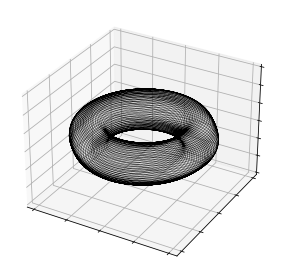

In [8]:
def dmd2torus(a1, a2):
    R1 = np.abs(a1)
    R2 = np.abs(a2)

    phi1 = np.angle(a1)
    phi2 = np.angle(a2)

    x1, y1 = R1*np.cos(phi1), R1*np.sin(phi1)
    x2, y2 = R2*np.cos(phi2), R2*np.sin(phi2)

    x = x1 + x2*np.cos(phi1)
    y = y1 + x2*np.sin(phi1)
    z = y2
    return x, y, z

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(4.5, 4))
ax = fig.gca(projection='3d')

x, y, z = dmd2torus(a_dmd[:, 0], a_dmd[:, 4])
ax.plot(x, y, z, 'k', lw=0.05)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_zlim([-0.03, .03])

plt.tight_layout()

So these two pairs of DMD coefficients evolve on a 2-torus, which would explain the quasiperiodic dynamics.  What about the other modes?

The answer is a bit complicated (again, see the paper on this topic), but the basic idea is that these are the "driving" degrees of freedom in the flow, while other modes are all generated by "triadic" nonlinear interactions of these dominant modes.  For instance, suppose we have pure oscillations
$$
\alpha_{1} \sim e^{i \omega_s t}
$$
$$
\alpha_{5} \sim e^{i \omega_c t},
$$
with $\alpha_2 = \alpha_1^*$ and $\alpha_6 = \alpha_5^*$ as complex conjugates.
Then a quadratic interaction like $\alpha_1 \alpha_5^*$ would force a higher-order mode at $\omega_s - \omega_c$.  The interaction of _that_ mode with $\alpha_1$ would force yet another mode at $\alpha_1^2 \alpha_5^* \sim e^{i(2\omega_s - \omega_c)t}$.  This pattern of cascading quadratic nonlinearities can therefore explain all of the discrete peaks in the power spectrum.

In short, because the flow is primarily advection-driven, we need many spatial modes to fully resolve the flow, but many fewer active dynamical degrees of freedom.  This is very similar to the seminal paper by [Noack, _et al_. (2003)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/hierarchy-of-lowdimensional-models-for-the-transient-and-posttransient-cylinder-wake/0F114BEB5DD20B7342E99ED8D0070C01) on the cylinder wake.  Other directions in the subspace may be active during transients, but they are quickly damped out until the flow evolves on the toroidal attractor visualized above.

Note that this torus visualization doesn't _prove_ that these two pairs of DMD modes can explain all of the dynamical behavior (everything else could just be evolving independently), though it is consistent with the power spectrum above. We'll proceed by assuming that these are the only four independent degrees of freedom in the post-transient flow, and try to approximate the other modes as functions of the active degrees of freedom.  That is, if $\boldsymbol{\alpha}$ is the set of the four "active" coefficients, we'll look for
$$
\boldsymbol{\alpha} = \mathbf{g}(\hat{\boldsymbol{\alpha}}).
$$

What should the form of $\mathbf{g}$ be?  Given the discussion about cascading triadic interactions above, a sparse polynomial function would be a good place to start.  We can use the "custom derivative" feature of PySINDy for this as well!  In other words, we'd write the approximation as
$$
\boldsymbol{\alpha} = \boldsymbol{\Theta}(\hat{\boldsymbol{\alpha}}) \boldsymbol{\xi}
$$
for a polynomial library $\boldsymbol{\Theta}$ and sparse coefficient vector $\boldsymbol{\xi}$.  This looks almost like the SINDy problem
$$
\dot{\mathbf{x}} = \boldsymbol{\Theta}(\mathbf{x}) \boldsymbol{\xi}
$$
except that in this case $\boldsymbol{\alpha}$ and $\hat{\boldsymbol{\alpha}}$ have different numbers of columns.

Future versions of PySINDy may be able to handle this kind of generalized sparse regression problem, but for now a workaround is to choose a truncation level that is a multiple of the number of active modes (four in this case), and then just loop through the variables.

In [25]:
# Take advantage of the fact that the DMD modes are complex conjugates
a_dmd_real = np.zeros(a_dmd.shape)
a_dmd_real[:,  ::2] = np.real(a_dmd[:, ::2])
a_dmd_real[:, 1::2] = np.imag(a_dmd[:, ::2])

In [27]:
r = 48
active_idx = [0, 1, 4, 5]
stable_idx = [i for i in range(r) if i not in active_idx]

x_train = a_dmd_real[:, active_idx]
t_train = t_dns.copy()

rhs = a_dmd_real[:, stable_idx]

niter = len(stable_idx) // len(active_idx)  # Number of sparse regression problems

In [35]:
# Fit the model
optimizer = pysindy.STLSQ(threshold=1e-1)
#optimizer = ps.FROLS(L0_penalty=1e-6)
library = pysindy.PolynomialLibrary(degree=3, include_bias=False)
model = pysindy.SINDy(
    optimizer=optimizer, feature_library=library
)

In [36]:
model.fit(x_train, t_train, x_dot=rhs[:, :len(active_idx)], quiet=True)
model.print()

x0' = 11.911 x0^2 + -12.468 x0 x1 + -11.913 x1^2
x1' = -6.229 x0^2 + -23.824 x0 x1 + 6.239 x1^2
x2' = 23.846 x0 x2 + 23.839 x1 x3
x3' = -23.842 x0 x3 + 23.845 x1 x2


In [37]:
library.fit(x_train)
Theta = library.transform(x_train)

In [40]:
from imp import reload
pysindy = reload(pysindy)

optimizer = pysindy.FROLS(L0_penalty=0.0, max_iter=10)
optimizer._reduce(Theta, rhs)

[]
[-7.94350563]
[-7.94350563 11.90996158]
[ -7.94350563  11.90996158 -12.46838445]
[-7.94350563e+00  1.19099616e+01 -1.24683845e+01  2.70514732e-04]
[-7.94350563e+00  1.19099616e+01 -1.24683845e+01  2.70514732e-04
  3.11782560e+00]
[-7.94350563e+00  1.19099616e+01 -1.24683845e+01  2.70514732e-04
  3.11782560e+00 -1.78491431e+00]
[-7.94350563e+00  1.19099616e+01 -1.24683845e+01  2.70514732e-04
  3.11782560e+00 -1.78491431e+00  1.04667547e+00]
[-7.94350563e+00  1.19099616e+01 -1.24683845e+01  2.70514732e-04
  3.11782560e+00 -1.78491431e+00  1.04667547e+00  1.41790615e+00]
[-7.94350563e+00  1.19099616e+01 -1.24683845e+01  2.70514732e-04
  3.11782560e+00 -1.78491431e+00  1.04667547e+00  1.41790615e+00
  6.32672532e+01]
[-7.94350563e+00  1.19099616e+01 -1.24683845e+01  2.70514732e-04
  3.11782560e+00 -1.78491431e+00  1.04667547e+00  1.41790615e+00
  6.32672532e+01 -2.80246873e-01]
[]
[-23.82406537]
[-23.82406537   4.1626861 ]
[-23.82406537   4.1626861   -6.22897656]
[-2.38240654e+01  4.162

In [41]:
optimizer.err_history_

array([  8.18468266,   4.43623561,   1.78115861,   1.04618835,
         1.50983267,   1.41222377,   1.41480424,   1.41575884,
         1.42129078, 145.25124916,  46.83095458,   8.18468266,
         8.18468266,   8.18468266,   8.18468266,   8.18468266,
         8.18468266,   8.18468266,   8.18468266,   8.18468266,
         8.18468266,   8.18468266,   8.18468266,   8.18468266,
         8.18468266,   8.18468266,   8.18468266,   8.18468266,
         8.18468266,   8.18468266,   8.18468266,   8.18468266,
         8.18468266,   8.18468266])

In [43]:
optimizer.coef_.shape

(44, 34)

In [151]:
model.fit(x_train, t_train, x_dot=rhs[:, :len(active_idx)], quiet=True)
model.print()

ValueError: Complex data not supported
[[ 0.00886093+0.02725144j  0.00886093-0.02725144j -0.0027395 -0.01004672j
  -0.0027395 +0.01004672j]
 [ 0.01197578+0.02603444j  0.01197578-0.02603444j -0.00245004-0.01011965j
  -0.00245004+0.01011965j]
 [ 0.01492743+0.02446281j  0.01492743-0.02446281j -0.00215823-0.01018429j
  -0.00215823+0.01018429j]
 ...
 [-0.02862331-0.0003027j  -0.02862331+0.0003027j   0.00595864-0.00877345j
   0.00595864+0.00877345j]
 [-0.02846324+0.00303974j -0.02846324-0.00303974j  0.00620868-0.0086025j
   0.00620868+0.0086025j ]
 [-0.02791823+0.00634102j -0.02791823-0.00634102j  0.00645112-0.00842221j
   0.00645112+0.00842221j]]


In [ ]:


# Fit the model
optimizer = ps.STLSQ(threshold=1e-1)
library = ps.PolynomialLibrary(degree=3)
model = ps.SINDy(
    optimizer=optimizer, feature_library=library
)
model.fit(x_train, t_train, quiet=True)
model.print()

In [59]:
def dmd2torus(a1, a2):
    R1 = np.abs(a1)
    R2 = np.abs(a2)

    phi1 = np.angle(a1)
    phi2 = np.angle(a2)

    x1, y1 = R1*np.cos(phi1), R1*np.sin(phi1)
    x2, y2 = R2*np.cos(phi2), R2*np.sin(phi2)

    x = x1 + x2*np.cos(phi1)
    y = y1 + x2*np.sin(phi1)
    z = y2
    return x, y, z


### POINCARE CUT

def stencil5(x, i, h=1):
    return (-x[i+2]+8*x[i+1]-8*x[i-1]+x[i-2])/(12*h)

def interp2zero(x, y):
    """
    When x~0, return interpolated value of y
    x - 1d array (n,)
    y - 2d array (n,d)
    """
    cross_idx = np.nonzero( (np.sign(x[1:]) != np.sign(x[:-1]) ) * (np.sign(x[:-1])==-1) )[0]
    y0 = np.zeros_like(y)[cross_idx]
    for i in range(len(cross_idx)):
        j = cross_idx[i]
        
        dx = stencil5(x, j)
        dy = stencil5(y, j)
        ym = y[j] - (dy/dx)*x[j]
        
        
        dx = stencil5(x, j+1)
        dy = stencil5(y, j+1)
        yp = y[j] - (dy/dx)*x[j]
        
        y0[i] = 0.5*(ym+yp)
    return y0

In [2]:
# Load training data

dt = 0.02
r = 2
n = r + 1

data_run1 = loadmat("data/PODcoefficients.mat")
x_run1 = np.concatenate(
    (data_run1["alpha"][:5000, :r], data_run1["alphaS"][:5000, 0:1]), axis=1
)
t_run1 = np.arange(0, dt * x_run1.shape[0], dt)

data_run2 = loadmat("data/PODcoefficients_run1.mat")
x_run2 = np.concatenate(
    (data_run2["alpha"][:3000, :r], data_run2["alphaS"][:3000, 0:1]), axis=1
)
t_run2 = np.arange(0, dt * x_run2.shape[0], dt)

x_train = [x_run1, x_run2]
t_train = [t_run1, t_run2]

In [3]:
# Fit the model

optimizer = ps.STLSQ(threshold=1e-4)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, feature_library=library, feature_names=["x", "y", "z"]
)
model.fit(x_train, t_train, multiple_trajectories=True, quiet=True)
model.print()

x' = -0.133 1 + -0.009 x + -1.023 y + -0.001 z + -0.002 y z
y' = -0.057 1 + 1.035 x + 0.005 y + 0.002 x z + -0.002 y z
z' = -20.653 1 + -0.294 z + 0.001 x^2 + 0.001 y^2 + -0.001 z^2


In [4]:
# Simulate the model

x_simulate_run1 = model.simulate(x_run1[0], np.arange(0, 100, 0.02))
x_simulate_run2 = model.simulate(x_run2[0], np.arange(0, 95, 0.02))

<ipython-input-5-a0520ebc2c55>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


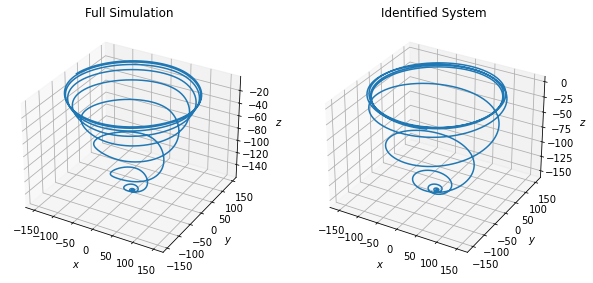

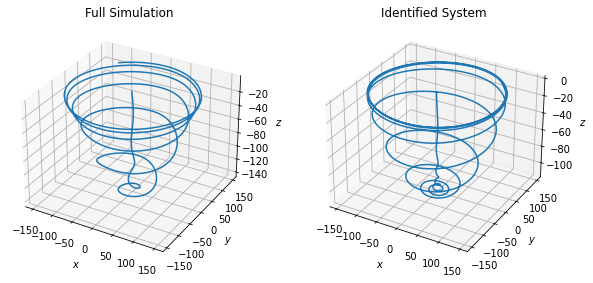

In [5]:
# Plot results

fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(121, projection="3d")
ax.plot(x_run1[:, 0], x_run1[:, 1], x_run1[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Full Simulation")

ax = fig.add_subplot(122, projection="3d")
ax.plot(x_simulate_run1[:, 0], x_simulate_run1[:, 1], x_simulate_run1[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Identified System")

fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(121, projection="3d")
ax.plot(x_run2[:, 0], x_run2[:, 1], x_run2[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Full Simulation")

ax = fig.add_subplot(122, projection="3d")
ax.plot(x_simulate_run2[:, 0], x_simulate_run2[:, 1], x_simulate_run2[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Identified System")
fig.show()